# Proyecto de Series de Tiempo
## Fernando Moreno, Frank Pedraza
### [totoro.banrep](https://totoro.banrep.gov.co/estadisticas-economicas/)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import random 

In [2]:
# para correr código R en colab
%load_ext rpy2.ipython

## Remesas de trabajadores, mensual

Unidad: Millones de USD

Fuente: Banco de la República

### Descripción de la serie

La serie consta de 271 realizaciones mensuales que van desde enero del 2000 a julio del 2022.

In [3]:
remesas = pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/Serie%20agregada%20de%20Remesas%20de%20trabajadores.csv')
remesas['Fecha']=pd.to_datetime(remesas['Fecha'])
[remesas.shape, min(remesas['Fecha']), max(remesas['Fecha'])]

[(271, 2), Timestamp('2000-01-31 00:00:00'), Timestamp('2022-07-31 00:00:00')]

+ Convertir a objeto Series

In [4]:
remesas['Fecha']=remesas['Fecha'].dt.date - pd.offsets.MonthBegin()
remesas=pd.Series(remesas['Millones de USD'].values,remesas['Fecha'], name='remesas')
remesas.index.freq='MS'
remesas.head()

Fecha
2000-01-01    103.751344
2000-02-01    145.837278
2000-03-01    125.347269
2000-04-01    115.880748
2000-05-01    129.341871
Freq: MS, Name: remesas, dtype: float64

+ Gráfico de las serie

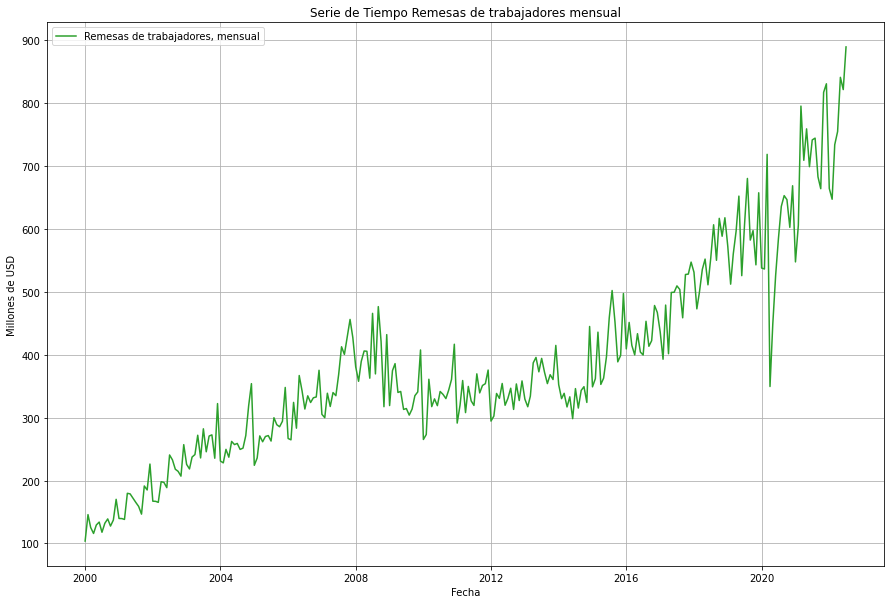

In [5]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(remesas, color='tab:green', label='Remesas de trabajadores, mensual')
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.set_title('Serie de Tiempo Remesas de trabajadores mensual')
ax.grid(True)
ax.legend(loc='upper left');

Al observar el gráfico de la serie lo primero que se evidencia es una tendencia creciente (la cual no parece ser una función suave), también se observa que la serie presenta indicios de varianza marginal no constante (en algunos instantes de tiempo la variabilidad parece ser mayor), por otra parte se concluye que la serie no estacionaria en el sentido débil, debido a que la media difiere a lo largo del tiempo, finalmente la serie parece no tener ciclo estacional, sin embargo más abajo a través de la serie diferenciada se determinará si hay presencia de ciclos ocultos en la serie.

In [6]:
#fig, ax = plt.subplots(1,2,figsize=(21,9))
#plot_acf(remesas,adjusted=False,lags=200,ax=ax[0],title='ACF Serie Remesas ')
#plot_pacf(remesas,lags=50,ax=ax[1],title='PACF Serie Remesas', method='ywmle')
#plt.show()

### Estabilización en varianza

Al observar el gráfico de la serie, una de las primeras acciones que estaríamos tentados a hacer es transformar la serie a escala logarítmica, debido a que se manejan unidades en millones de USD y se busca estabilizar la varianza de la serie, Sin embargo para evaluar si es la transformación indicada se hará uso de la metodología basada en transformación de tipo Box-Cox, en la cual se estima un parámetro $\lambda$ a través de cualquiera de las dos formas (loglik y guerrero) en las que está implementada en el software.

+ **Transformación Box-Cox**

In [7]:
import scipy as sp
import scipy.stats 
sp.stats.boxcox(remesas,alpha=0.05) #(0.058, 0.522) #Data must be positive

(array([ 9.76761319, 11.1344932 , 10.51008057, 10.19681686, 10.63722743,
        10.78210855, 10.26142549, 10.72354002, 10.93330437, 10.5831735 ,
        10.87940283, 11.79897059, 10.9550986 , 10.94927701, 10.90979771,
        12.04240013, 12.019185  , 11.84493574, 11.67260959, 11.50008528,
        11.15714431, 12.32601601, 12.1736716 , 13.10733419, 11.72165756,
        11.71543741, 11.67325283, 12.48606965, 12.45977641, 12.26210348,
        13.4065363 , 13.24659283, 12.93100314, 12.85863014, 12.68804634,
        13.7306921 , 13.09632121, 12.94087697, 13.33907647, 13.41930171,
        14.01372878, 13.30996076, 14.2012351 , 13.50837309, 13.99040861,
        14.02445844, 13.30013851, 14.8917562 , 13.20827222, 13.1474622 ,
        13.58475318, 13.33466417, 13.82897646, 13.73312792, 13.7675962 ,
        13.58285802, 13.62353223, 14.0044453 , 14.83397619, 15.39562494,
        13.06509909, 13.309225  , 13.99416495, 13.81909129, 13.97691438,
        14.00392368, 13.84013454, 14.5125496 , 14.3

In [8]:
%%R
#install.packages("forecast")
#install.packages("FitAR")

NULL


In [ ]:
%%R
library(forecast)
#library(FitAR) # genera error en colab

In [10]:
# -i pasar los datos de entorno python a R (analogamente -o: pasar los datos de entrono R a python)
%R -i remesas

In [11]:
%%R 
forecast::BoxCox.lambda(remesas, method = "guerrero", lower = -1, upper = 3)

[1] 0.08589458


Dado que la estimación de $\lambda$ a través de los dos métodos (loglik y guerreo) lleva a la misma concluisón $\lambda > 0$, la transformación para estabilizar la varianza en este caso es la siguiente:

$$ f_{\lambda}(r_{t}) = \lambda^{-1} (r_{t}^{\lambda}-1)) \quad\text{donde $r_t$: remesas en el tiempo $t$}$$


In [12]:
bc_remesas=sp.stats.boxcox(remesas,lmbda=0.08589458).rename('BC_remesas')
remesas2 = pd.concat([remesas, bc_remesas], axis=1)
remesas2.head()

,remesas,BC_remesas
Fecha,,
2000-01-01,103.751344,5.703735
2000-02-01,145.837278,6.218536
2000-03-01,125.347269,5.987766
2000-04-01,115.880748,5.869252
2000-05-01,129.341871,6.035336


In [13]:
%R -i remesas2

In [14]:
%%R
forecast::BoxCox.lambda(remesas2$BC_remesas, method = "guerrero", lower = -1, upper = 3)

[1] 1.075401


Ahora usamos la misma función para verificar si en verdad la varianza fue estabilizada, en este caso $\lambda$ da un valor cercano a 1 con lo cual se verifica que la tranformación Box-Cox implementada fue la adecuada.

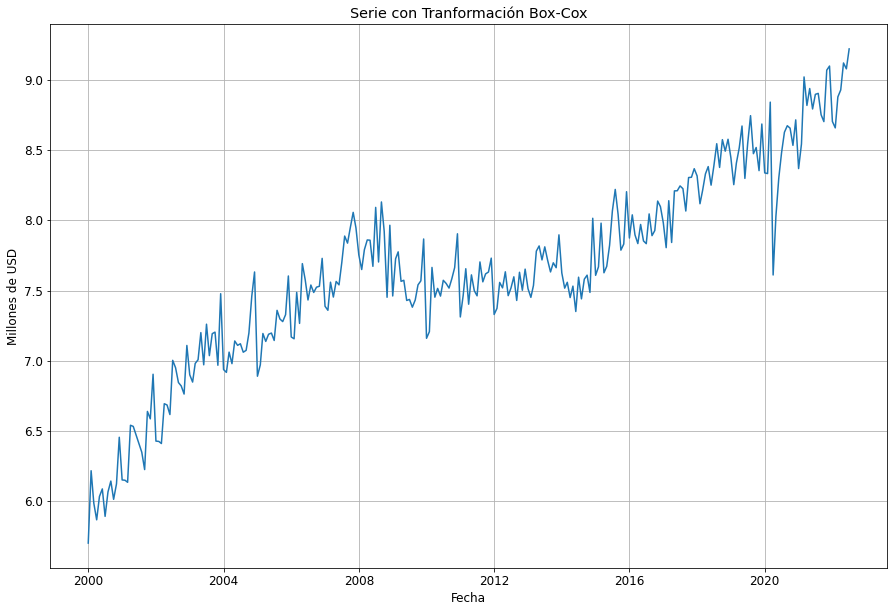

In [15]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(remesas2['BC_remesas'])
plt.title('Serie con Tranformación Box-Cox') 
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.grid(True)
plt.show()

In [16]:
%%R
#remesas2%>% timetk::plot_time_series(Fecha, BC_remesas, .interactive = TRUE)

NULL


### Exploración de asociación lineal

Antes de chequear las relaciones lineales entre la serie y sus propios rezagos, se explora la matriz de diagramas de dispersión de la variable original $r_t$ con sus propios rezagos $r_{t-k}$, lo que nos permite identificar posibles relaciones no-lineales. 

In [ ]:
%%R
#install.packages("astsa")
library(astsa)

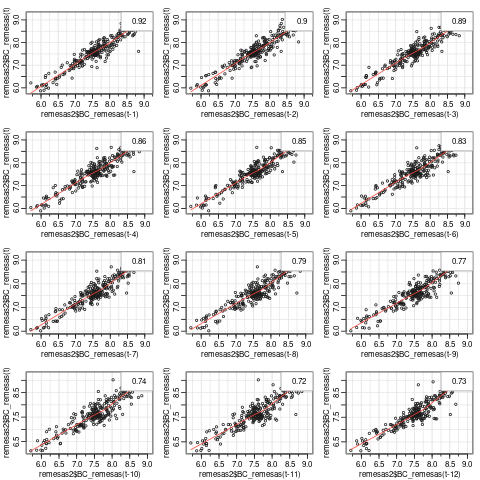

In [18]:
%%R
#knitr::opts_chunk$set(fig.width=16, fig.height=9) 
par(mar = c(3,2,3,2))
astsa::lag1.plot(remesas2$BC_remesas, 12)

De la matriz de diagramas de dispersión se puede observar que exiten relaciones lineales positivas a lo largo de los 12 primeros rezagos, lo cual resulta llamativo, por lo que se procede a explorar la información mutua promedio (AMI), la cual se define como: 

$$I(X;Y)=\sum_{i}\sum_{j}p(x_i,y_j)\log_2(\frac{p(x_i,y_j)}{p(x_i)p(y_j)}).$$

En el contexto del análisis de series de tiempo, AMI ayuda a cuantificar la cantidad de conocimiento obtenido sobre el valor de $X_{t+d}$ al observar $X_t$. 
I(X; Y ) describe la información que la medición $X_t$ en el tiempo $t$ aporta a la medición $X_{t+d}$ en el tiempo $t + d$. Si se elige $d$ como el valor alrededor del primer mínimo del AMI, entonces $Y{t}$ e $y_{t+d}$ son parcialmente pero no totalmente independientes.


In [19]:
%%R
#install.packages("nonlinearTseries")
#library(nonlinearTseries)
#install.packages("tseriesChaos")
library(tseriesChaos)

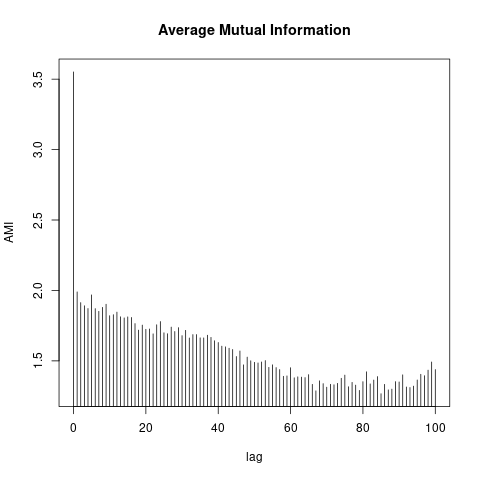

In [20]:
%%R
#nonlinearTseries::mutualInformation(remesas,lag.max = 100,n.partitions = 50,units = "Bits",do.plot = TRUE) #c("Nats", "Bits", "Bans")
tseriesChaos::mutual(remesas2$BC_remesas, partitions = 50, lag.max = 100, plot=TRUE)

### Detección de ciclos y estacionalidades

Un enfoque para analizar patrones estacionales en la serie es mediante el uso de histogramas o gráficos de densidad, lo cual nos permite examinar si cada uno de los meses tiene una distribución única que puede distinguirla del resto de meses.

In [ ]:
%%R
#install.packages("rlang", version = "1.0.3")
#install.packages("timetk")
library(timetk)
library(lubridate)

In [22]:
%%R
remesas2$Fecha = rownames(remesas2)
remesas2$Fecha = ymd_hms(remesas2$Fecha)
remesas2$Mes = month(remesas2$Fecha, label = TRUE)
#remesas2 %>% plot_seasonal_diagnostics(.date_var = Fecha, .value = remesas, .feature_set = c("month.lbl"),.geom="boxplot",  .interactive = F)

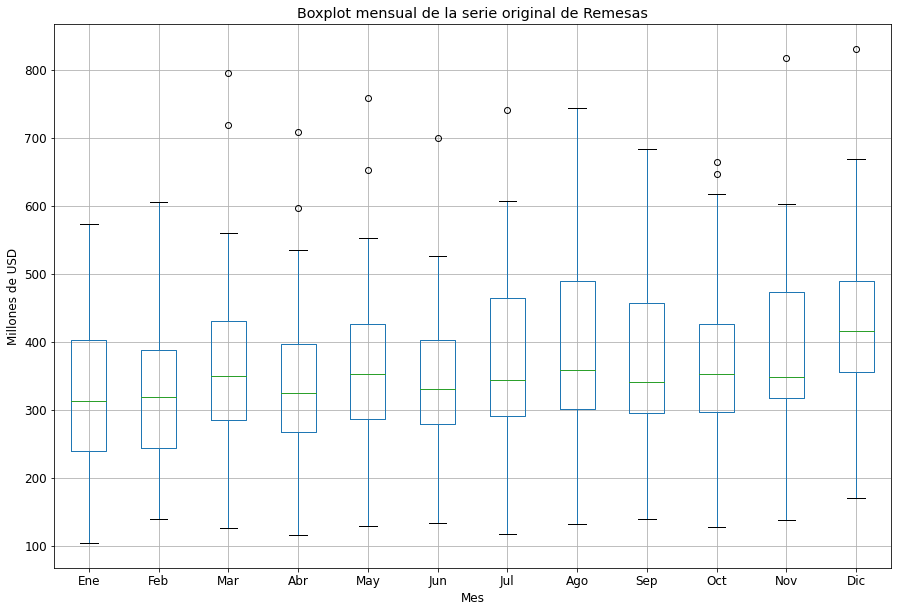

In [23]:
month=['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
#rm=np.array(remesas2['BC_remesas'].iloc[0:264]).reshape(22,12)
rm=np.array(remesas.iloc[0:264]).reshape(22,12)
rmd=pd.DataFrame(rm, columns=month)

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))
bpm=rmd.boxplot()
plt.title('Boxplot mensual de la serie original de Remesas') 
ax.set_xlabel('Mes')
ax.set_ylabel('Millones de USD')
plt.show()

A partir del gráfico de Boxplot se observa las diferencias en variabilidad en cada uno de los meses, además se observa que la mediana de las remesas del mes de diciembre es mayor que en el resto de meses, en los cuales se ecnuentra entre 300 y 400 Millones de USD. 

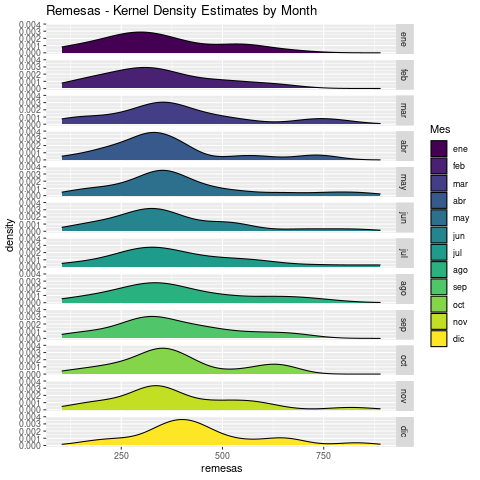

In [24]:
%%R
library(ggplot2)
ggplot(remesas2, aes(x = remesas)) +
#ggplot(remesas2, aes(x = BC_remesas)) +
      geom_density(aes(fill = Mes)) +
      ggtitle("Remesas - Kernel Density Estimates by Month") +
      facet_grid(rows = vars(as.factor(Mes)))

Se puede observar que la densidad de la serie original en cada uno de los meses tiene un sesgo a derecha, además que para el mes de diciembre el punto de más alta densidad parece ser un valor de remesas (en Millones de USD) mayor que el de los demás meses. Una vez se elimine la tendencia de la serie de tiempo se podrá determinar si la serie tiene ciclos ocultos.

### Suavizamiento de la serie de tiempo

A continuación se implementan algunos métodos para descubrir en la serie de tiempo con transformación Box Cox componentes como tendencia y estacionalidad.

In [25]:
%%R
library(astsa)
data(soi)

In [26]:
%%R
rms = ts(remesas2$BC_remesas, frequency = 12, start = c(2000, 1))       

+ Promedio Móvil

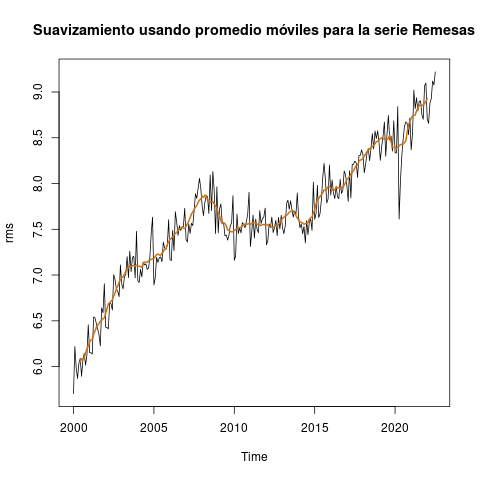

In [27]:
%%R
wgts = c(rep(1,12))/12   ###Los pesos de los filtros
rmsf = stats::filter(rms, filter=wgts, method = "convolution", sides=2) # if sides = 2 they are centred around lag 0.
plot.ts(rms, main = "Suavizamiento usando promedio móviles para la serie Remesas")
lines(rmsf, lwd=2, col=7)

+ LOESS

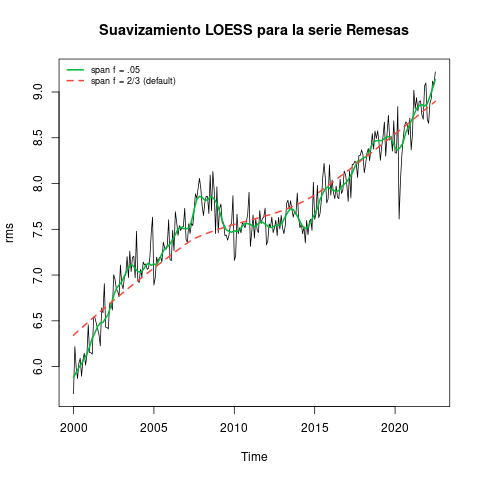

In [28]:
%%R
plot.ts(rms, main = "Suavizamiento LOESS para la serie Remesas")
lines(lowess(rms, f=.05), lwd=2, col=3)  
lines(lowess(rms), lty=2, lwd=2, col=2)  # tendencia (con span por defecto)
legend("topleft", c("span f = .05", "span f = 2/3 (default)"), lty = c(1,2), lwd = c(2,2), col = c(3,2), cex = 0.75, bty = "n")

+ Exponencial (Holt-Winters)

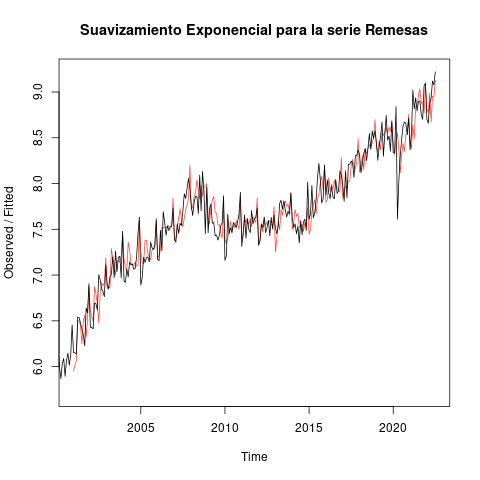

In [29]:
%%R
HWAP=stats::HoltWinters(rms,seasonal="additive") 
plot(HWAP, main = "Suavizamiento Exponencial para la serie Remesas")

En los anteriores gráficos de suavizamiento de la serie transformada se estimó la componente de tendencia a través de diferentes métodos, sin embargo se puede descomponer la serie en componentes de tendencia y estacional de forma autómatica, como se ilustra a continuación con el filtro de promedios móviles.

+ Descomposición usando promedios móviles

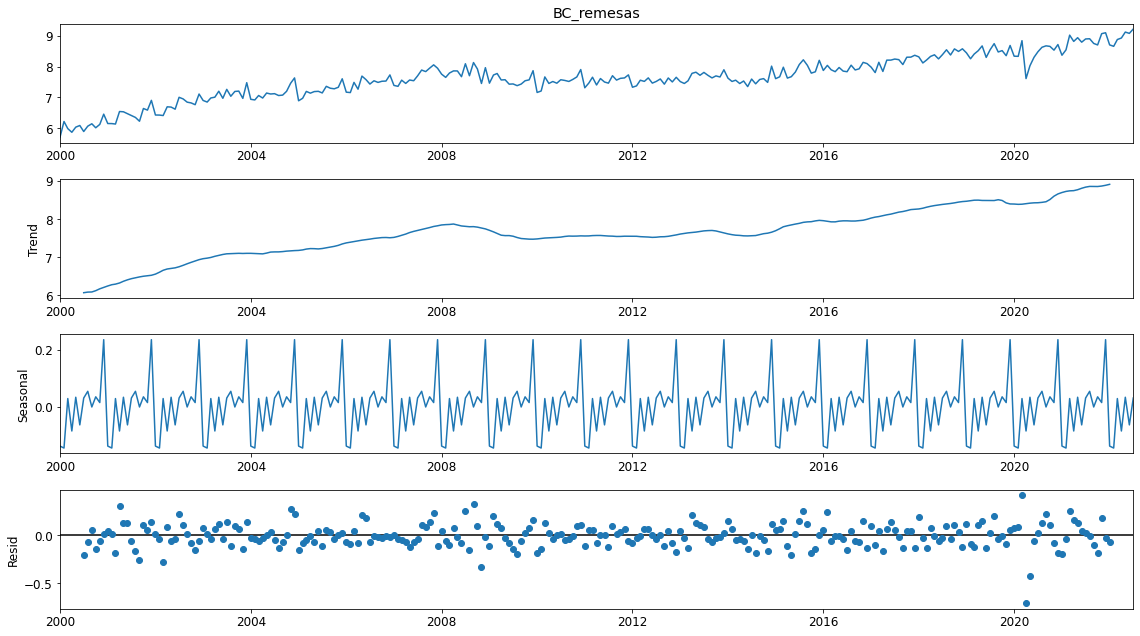

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 9
#%%R
#desrms=decompose(rms)
#plot(desrms)
rmsdeca = seasonal_decompose(remesas2['BC_remesas'], model = 'additive')
rmsdeca.plot()
plt.show()

+ Seasonal-Trend decomposition with LOESS (STL)

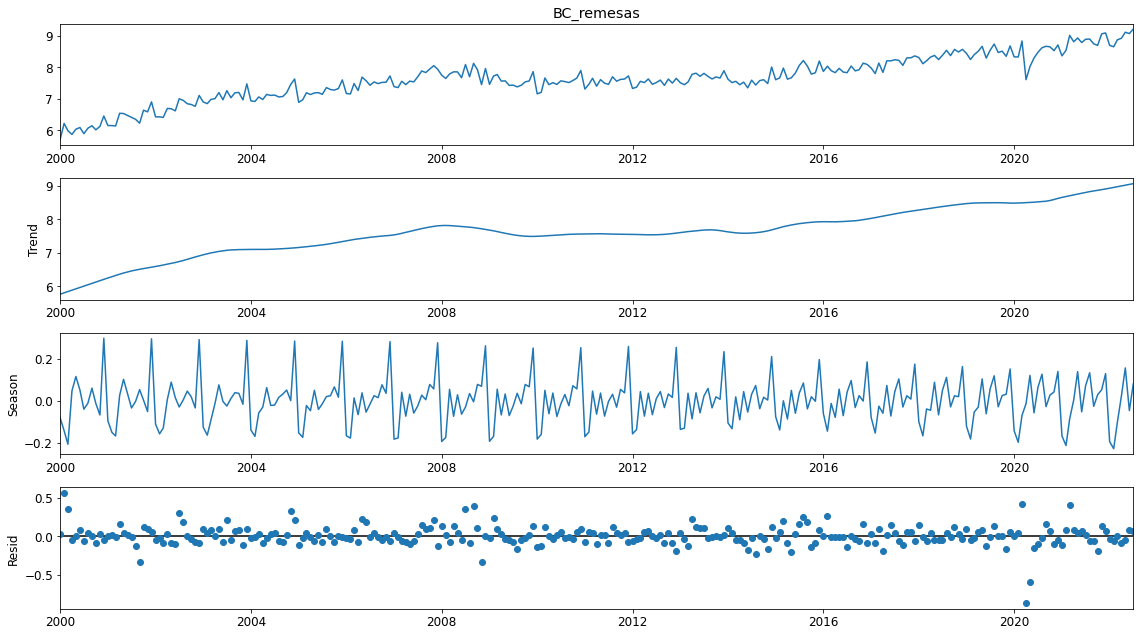

In [31]:
rms_stl = STL(
remesas2['BC_remesas'],
seasonal=13, # the seasonal smoother and can only take odd integer values greater than or equal to 7
robust=True).fit()

rms_stl.plot()
plt.show()

+ Exponencial (Holt-Winters)

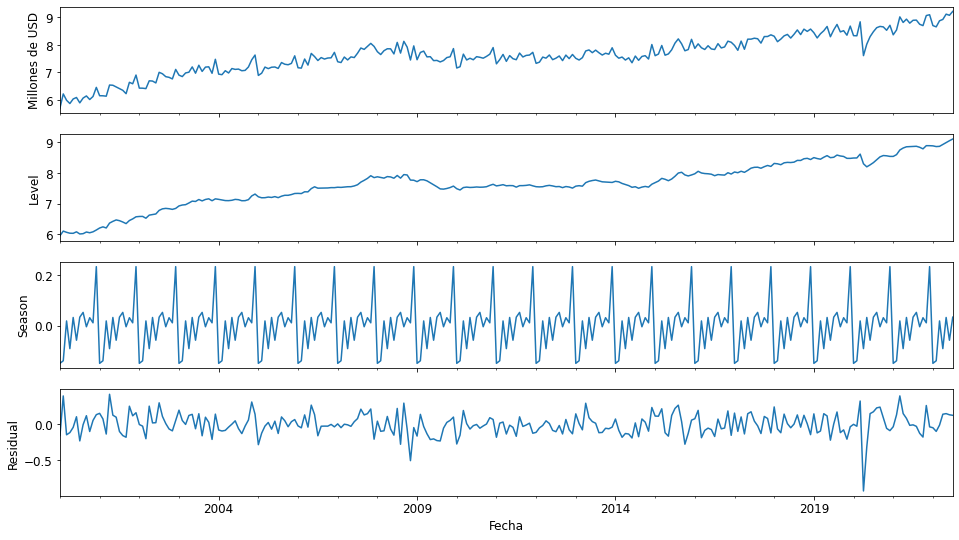

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.tsa.holtwinters as ets
xhwfit = ExponentialSmoothing(remesas2['BC_remesas'],trend = 'add',seasonal = 'add', seasonal_periods = 12).fit()

ax1 = plt.subplot(411);remesas2['BC_remesas'].plot();
plt.setp(ax1.get_xticklabels(),visible = False); 
plt.ylabel('Millones de USD')
ax2 = plt.subplot(412,sharex = ax1);xhwfit.level.plot();
plt.setp(ax2.get_xticklabels(),visible = False); plt.ylabel('Level')
ax3 = plt.subplot(413, sharex = ax1); xhwfit.season.plot();
plt.ylabel('Season') 
ax4 = plt.subplot(414,sharex = ax1);xhwfit.resid.plot();
plt.setp(ax3.get_xticklabels(),visible = False); plt.ylabel('Residual')
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad = 1.5)
plt.show()

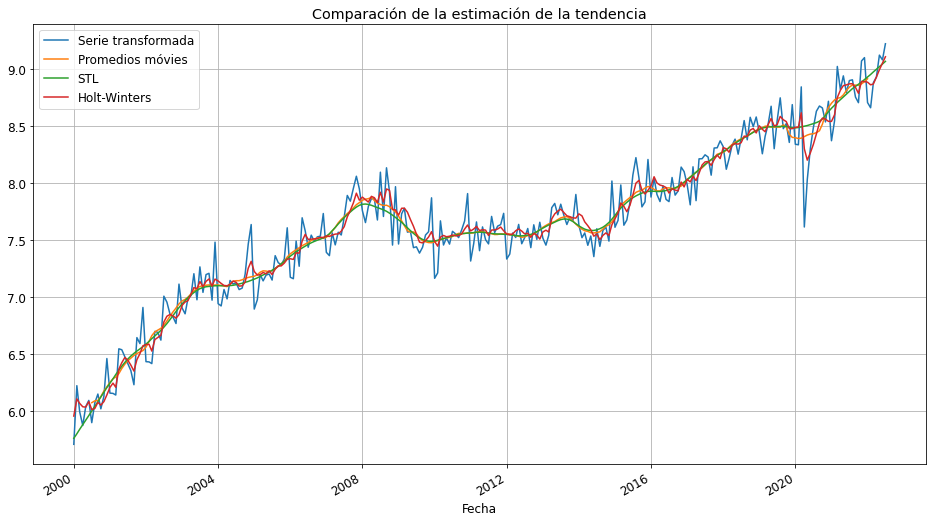

In [33]:
plt.plot(remesas2['BC_remesas'])
rmsdeca.trend.plot()
rms_stl.trend.plot()
xhwfit.level.plot()
plt.title("Comparación de la estimación de la tendencia")
plt.grid(True)
plt.legend(['Serie transformada','Promedios móvies', 'STL', "Holt-Winters"]);
plt.show()

### Eliminación de la tendencia

A continuación se busca eliminar la tendencia lineal de la serie de Remesas, diferenciando la serie de forma ordinaria una sola vez.

In [34]:
dif_remesas=remesas2['BC_remesas'].diff(periods=1)

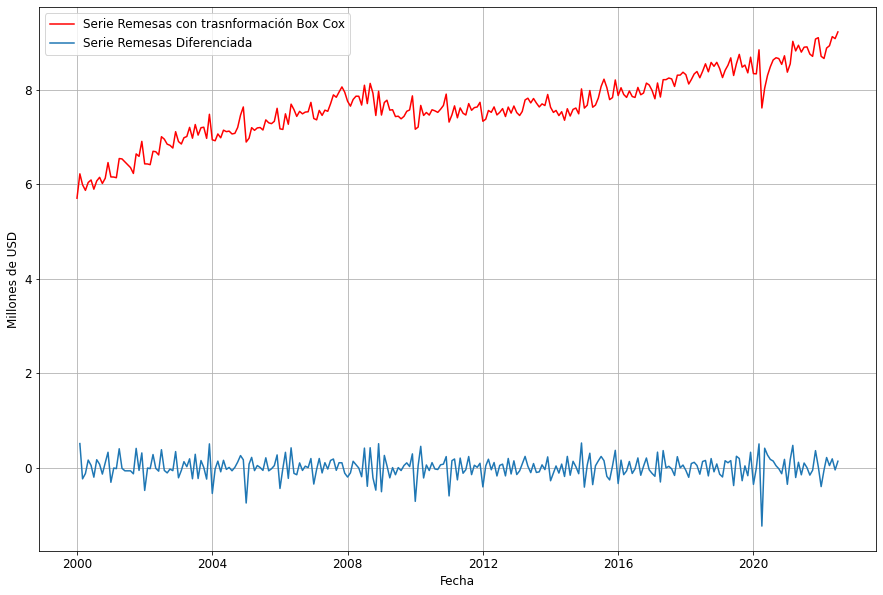

In [35]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(remesas2['BC_remesas'], 'r', label="Serie Remesas con trasnformación Box Cox")
ax.plot(dif_remesas, '-', label="Serie Remesas Diferenciada")
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.grid(True)
ax.legend(loc="best");

### Gráficos ACF y PACF para identificación de modelos AR(p) y MA(q) puros

In [36]:
%R -i dif_remesas

In [37]:
%%R
remesas2$dif_remesas = dif_remesas
#dif_rms = ts(na.omit(dif_remesas), frequency = 12, start = c(2000, 2))       

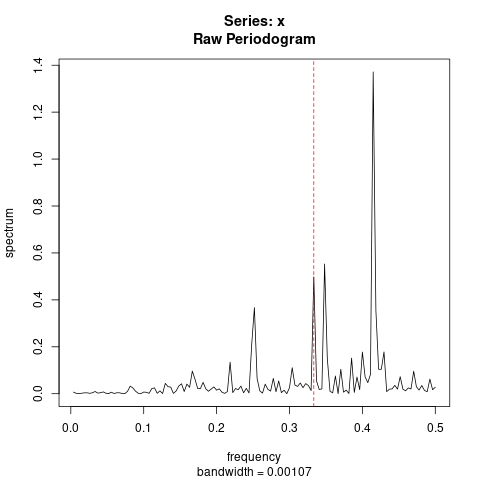

In [38]:
%%R
p2 = spectrum(na.omit(remesas2$dif_remesas),log="no")
abline(v = 1/3, lty = 2, col = "red")

In [39]:
%%R
dd = data.frame(freq=p2$freq, spec=p2$spec)
order = dd[order(-dd$spec),]
top3 = head(order, 3)
 
time = 1/top3$f
time

[1] 2.410714 2.872340 3.000000


En una serie mensual se espera encontrar un valor alto del periodograma para $f = 1/12$ pero también para $f = j/12 \quad\text{ con $j = 1,2,\ldots, t$}$, que son armónicos del periodo estacional, en este caso encontramos que un pico se ecuentra en $f = 1/3$, sin embargo se observa que hay otras frecuencias principales las cuales no corresponden a frecuencias básicas (fracciones exactas del tamaño muestral).

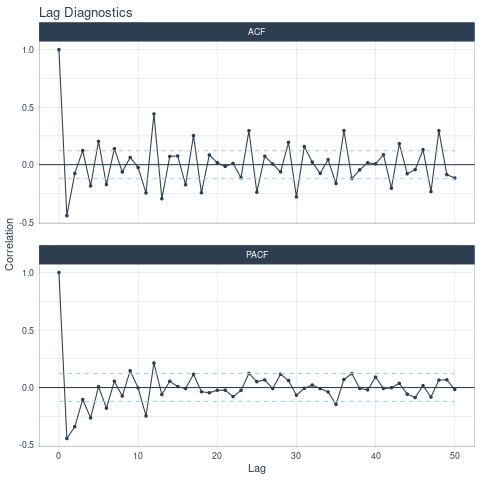

In [40]:
%%R
remesas2%>%timetk::plot_acf_diagnostics(
       Fecha, dif_remesas,               # ACF & PACF
        .lags = 50,          # 7-Days of hourly lags
        .interactive = FALSE)

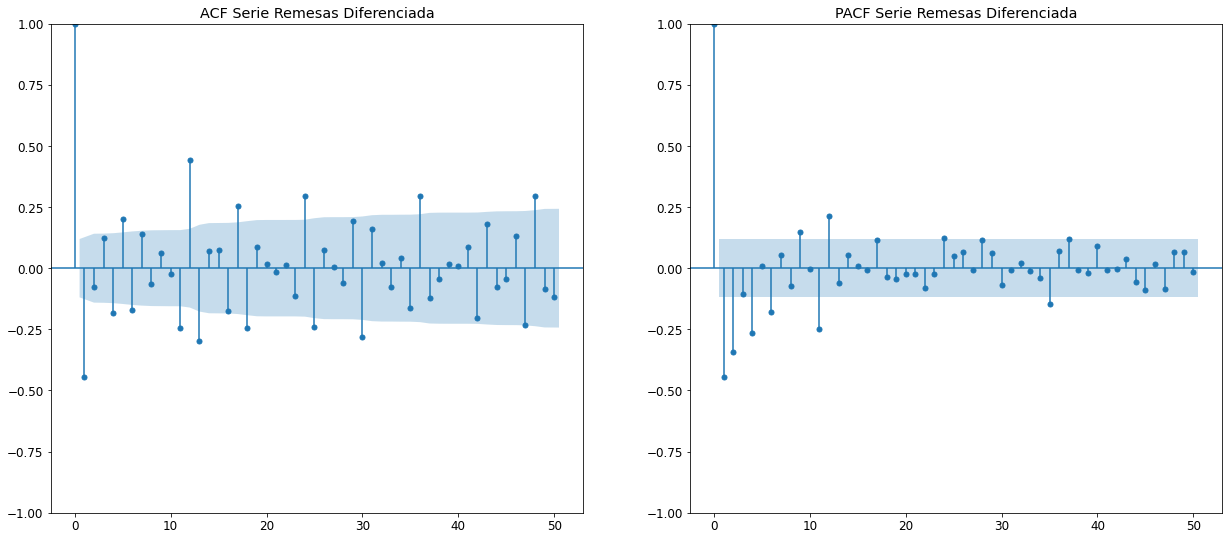

In [41]:
fig, ax = plt.subplots(1,2,figsize=(21,9))
plot_acf(dif_remesas.dropna(),adjusted=False,lags=50,ax=ax[0],title='ACF Serie Remesas Diferenciada')
plot_pacf(dif_remesas.dropna(),lags=50,ax=ax[1],title='PACF Serie Remesas Diferenciada', method='ywmle')
plt.show()

Tanto en el gráfico de la función de autocorrelación (ACF) como en el PACF se evidencia que los rezagos 1 y 12 tienen un valor alto lo que sugiere una fuerte asociación estadística tanto negativa como postiva respectivamente, además se observa que hay rezagos de ordenes grandes para los cuales los valores de la ACF caen por fuera del intervalo de confianza para un modelo MA, sin embargo por el contexto del problema no hace sentido que la remesas de 15,20,25 o 30 meses atrás influencien lo que ocurre con las remesas en el mes actual, se procede a ajustar modelos AR(12) y MA(12) puros.

### Ajuste y selección de modelos de series de tiempo

#### AR(12)

In [42]:
from statsmodels.tsa.arima.model import ARIMA #https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
from statsmodels.tsa.statespace.sarimax import SARIMAX #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [43]:
#ajuste de un AR(12)
AR=ARIMA(dif_remesas,order=(12,0,0),trend='c') # ‘c’ indicates a constant term, ‘t’ indicates a linear trend in time, and ‘ct’ includes both
fitAR=AR.fit() 
print(fitAR.summary()) #son significativos AR1-AR4 y AR12

                               SARIMAX Results                                
Dep. Variable:             BC_remesas   No. Observations:                  271
Model:                ARIMA(12, 0, 0)   Log Likelihood                 100.097
Date:                jue, 27 oct 2022   AIC                           -172.194
Time:                        20:10:40   BIC                           -121.764
Sample:                    01-01-2000   HQIC                          -151.946
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0117      0.004      2.952      0.003       0.004       0.019
ar.L1         -0.5947      0.061     -9.680      0.000      -0.715      -0.474
ar.L2         -0.5018      0.074     -6.751      0.0

+ AR final

In [44]:
#ar_orden=[1,1,1,1,1,1,1,1,1,1,0,1] # ar.L10: -0.092
#ar_orden=[1,1,1,1,1,1,1,1,1,0,0,1] #ar.L9: 0.090 
#ar_orden=[1,1,1,1,1,1,1,1,0,0,0,1] #ar.L8: 0.764
#ar_orden=[1,1,1,1,1,1,1,0,0,0,0,1] #ar.L7: 0.828 
#ar_orden=[1,1,1,1,1,1,0,0,0,0,0,1] #ar.L6: 0.034 (significativo!!!) #ar.L5: 0.117
#ar_orden=[1,1,1,1,0,1,0,0,0,0,0,1] #ar.L6: 0.123
ar_orden=[1,1,1,1,0,0,0,0,0,0,0,1]
AR12 = SARIMAX(dif_remesas, trend='c', order=(ar_orden,0,0))  
fit2AR12=AR12.fit()

In [45]:
print(fit2AR12.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          BC_remesas   No. Observations:                  271
Model:             SARIMAX([1, 2, 3, 4, 12], 0, 0)   Log Likelihood                  93.379
Date:                             jue, 27 oct 2022   AIC                           -172.759
Time:                                     20:10:47   BIC                           -147.544
Sample:                                 01-01-2000   HQIC                          -162.635
                                      - 07-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0264      0.011      2.295      0.022       0.004       0.049
ar.L1         -0.5636      

#### MA(12)

In [46]:
MA=ARIMA(dif_remesas,order=(0,0,12),trend='c') # ‘c’ indicates a constant term, ‘t’ indicates a linear trend in time, and ‘ct’ includes both
fit_MA=MA.fit() 
print(fit_MA.summary()) #son significativos MA1-MA2 y MA12

                               SARIMAX Results                                
Dep. Variable:             BC_remesas   No. Observations:                  271
Model:                ARIMA(0, 0, 12)   Log Likelihood                  86.486
Date:                jue, 27 oct 2022   AIC                           -144.972
Time:                        20:10:55   BIC                            -94.542
Sample:                    01-01-2000   HQIC                          -124.724
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.005      2.603      0.009       0.003       0.021
ma.L1         -0.5729      0.065     -8.810      0.000      -0.700      -0.445
ma.L2         -0.1635      0.062     -2.652      0.0

/home/fm/anaconda3/envs/TCI_FM/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


+ MA final

In [47]:
#ma_orden=[1,1,1,1,1,1,1,1,1,1,0,1] #ma.L10: 0.290
#ma_orden=[1,1,1,1,1,1,1,1,1,0,0,1] #ma.L9: 0.005 (significativo) # ma.L8: 0.159 
#ma_orden=[1,1,1,1,1,1,1,0,1,0,0,1] #ma.L7: 0.471
#ma_orden=[1,1,1,1,1,1,0,0,1,0,0,1] #ma.L6:0.461
ma_orden=[1,1,1,1,1,0,0,0,1,0,0,1] 
MA12 = SARIMAX(dif_remesas, trend='c', order=(0,0,ma_orden))  
fit2_MA12=MA12.fit()

In [48]:
print(fit2_MA12.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                BC_remesas   No. Observations:                  271
Model:             SARIMAX(0, 0, [1, 2, 3, 4, 5, 9, 12])   Log Likelihood                  83.568
Date:                                   jue, 27 oct 2022   AIC                           -149.136
Time:                                           20:11:02   BIC                           -116.717
Sample:                                       01-01-2000   HQIC                          -136.119
                                            - 07-01-2022                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0120      0.005      2.665      0.008    

#### ARMA(12,2)

In [49]:
ARMA12 = SARIMAX(dif_remesas, trend='c', order=(12,0,12))
fit_ARMA12=ARMA12.fit()

In [50]:
print(fit_ARMA12.summary()) # los coeficientes del MA no son significativos

                               SARIMAX Results                                
Dep. Variable:             BC_remesas   No. Observations:                  271
Model:             SARIMAX(12, 0, 12)   Log Likelihood                 107.308
Date:                jue, 27 oct 2022   AIC                           -162.615
Time:                        20:11:16   BIC                            -68.960
Sample:                    01-01-2000   HQIC                          -125.012
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0124      0.012      0.996      0.319      -0.012       0.037
ar.L1         -0.2238      0.309     -0.724      0.469      -0.829       0.382
ar.L2          0.1624      0.287      0.566      0.5

+ ARMA final 

In [51]:
#ar_orden=[1,1,1,1,1,1,1,1,1,1,0,1] #ar.L10: 0.089 
#ma_orden=[1,1,1,1,1,1,1,1,1,1,0,1] #ma.L10: 0.142
#ar_orden=[1,1,1,1,1,1,1,1,1,0,0,1] #ar.L9: 0.173 
#ma_orden=[1,1,1,1,1,1,1,1,1,0,0,1] #ma.L9: 0.476
#ar_orden=[1,1,1,1,1,1,1,1,0,0,0,1] #ar.L8: 0.151 
#ma_orden=[1,1,1,1,1,1,1,1,0,0,0,1] #ma.L8: 0.000 (significativo!!!) # ma.L7: 0.978
#ar_orden=[1,1,1,1,1,1,1,0,0,0,0,1] #ar.L7:0.227
#ma_orden=[1,1,1,1,1,1,0,1,0,0,0,1] #ma.L6: 0.196
#ar_orden=[1,1,1,1,1,1,0,0,0,0,0,1] #ar.L6: 0.215
#ma_orden=[1,1,1,1,1,0,0,1,0,0,0,1] #ma.L5: 0.186
#ar_orden=[1,1,1,1,1,0,0,0,0,0,0,1] #ar.L5: 0.185
#ma_orden=[1,1,1,1,0,0,0,1,0,0,0,1] #ma.L4: 0.09
#ar_orden=[1,1,1,1,0,0,0,0,0,0,0,1] #ar.L4: 0.074
#ma_orden=[1,1,1,0,0,0,0,1,0,0,0,1] #ma.L3: 0.201
#ar_orden=[1,1,1,0,0,0,0,0,0,0,0,1] #ar.L3: 0.000 (significativo!!!)
#ma_orden=[1,1,0,0,0,0,0,1,0,0,0,1] #ma.L8: 0.485 
#ar_orden=[1,1,1,0,0,0,0,0,0,0,0,1] #ar.L1: 0.358
#ma_orden=[1,1,0,0,0,0,0,0,0,0,0,1] #ma.L12: 0.123
ar_orden=[0,1,1,0,0,0,0,0,0,0,0,1] #ar.L1: 0.358
ma_orden=[1,1,0,0,0,0,0,0,0,0,0,0] #ma.L12: 0.123
ARMA12 = SARIMAX(dif_remesas, order=(ar_orden,0,ma_orden))
fit_ARMA12=ARMA12.fit()

In [52]:
print(fit_ARMA12.summary()) 

                                   SARIMAX Results                                   
Dep. Variable:                    BC_remesas   No. Observations:                  271
Model:             SARIMAX([2, 3, 12], 0, 2)   Log Likelihood                  88.119
Date:                       jue, 27 oct 2022   AIC                           -164.239
Time:                               20:11:33   BIC                           -142.626
Sample:                           01-01-2000   HQIC                          -155.561
                                - 07-01-2022                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.2903      0.049      5.918      0.000       0.194       0.386
ar.L3          0.2643      0.048      5.468      0.000       0.170       0.

#### ARIMA automático ARIMA(2,0,5)

In [53]:
import pmdarima.arima as pm #https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
fit_auto=pm.auto_arima(dif_remesas,start_p=12,start_q=12, max_p=12, max_q=12, d=0, D=0, seasonal=False)
print(fit_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  271
Model:               SARIMAX(2, 0, 5)   Log Likelihood                  88.810
Date:                jue, 27 oct 2022   AIC                           -161.619
Time:                        20:11:45   BIC                           -132.802
Sample:                    01-01-2000   HQIC                          -150.049
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7236      0.012   -138.388      0.000      -1.748      -1.699
ar.L2         -0.9954      0.012    -82.474      0.000      -1.019      -0.972
ma.L1          1.1763      0.064     18.307      0.0

### Criterios de Información AIC y BIC de los modelos seleccionados

In [54]:
CritInfo = pd.DataFrame({'Modelos' : ['AR(12)', 'MA(12)', 'ARMA(12,2)', 'ARIMA(2,0,5)'],
                         'AIC': [fit2AR12.aic, fit2_MA12.aic, fit_ARMA12.aic, fit_auto.aic()],
                         'BIC': [fit2AR12.bic, fit2_MA12.bic, fit_ARMA12.bic, fit_auto.bic()]})
round(CritInfo, 2)

,Modelos,AIC,BIC
0,AR(12),-172.76,-147.54
1,MA(12),-149.14,-116.72
2,"ARMA(12,2)",-164.24,-142.63
3,"ARIMA(2,0,5)",-161.62,-132.80


A partir de la tabla anterior el modelo con menor AIC y BIC es el autoregresivo de orden 12. 

### Comprobación de los supuestos

#### modelo AR(12)

+ Normalidad de los residuales

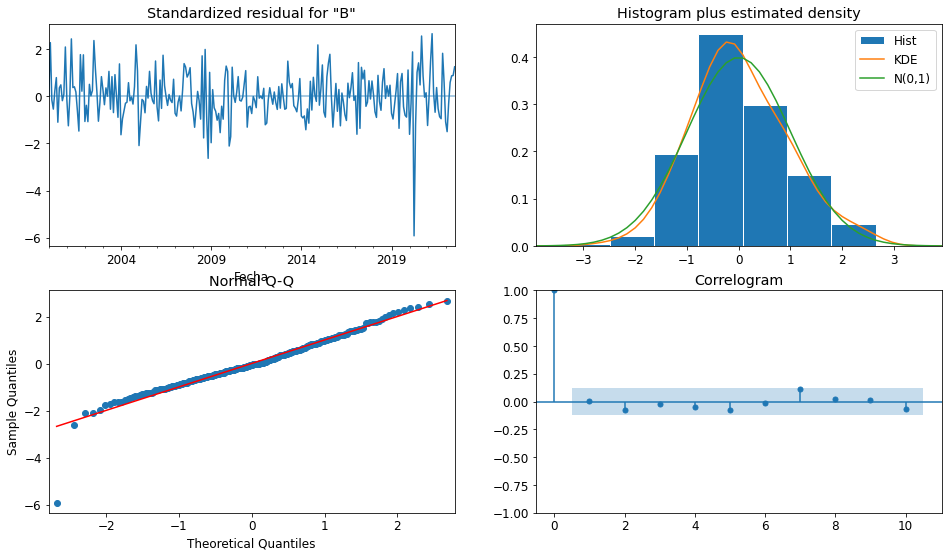

In [55]:
fit2AR12.plot_diagnostics()
plt.show()

+ Residuales modelo ARMA(12,2)

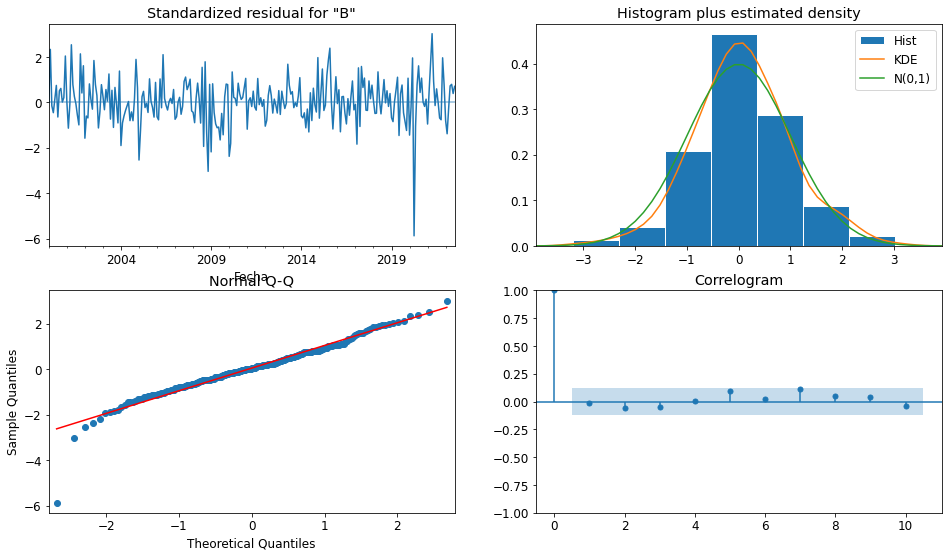

In [56]:
fit_ARMA12.plot_diagnostics()
plt.show()